In [1]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import kagglehub
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Your device is using {device}")

Your device is using cuda


In [2]:
data_path = kagglehub.dataset_download("hubashaikh/ham-vs-spam-sms-classification-dataset")
print('Data source import complete.')

data_path = data_path + "\\SMS_spam_collection.csv"
df = pd.read_csv(data_path)
df.dropna(inplace=True)

print("\n\ninformation of dataset:\n")
print(df.info())
df.head(4)

Data source import complete.


information of dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...


In [3]:
class SMSDataset(Dataset):
    def __init__(self, dataframe, tokenizer_name='bert-base-uncased', max_length=None):
        self.dataframe = dataframe.copy()
        self.tokenizer = self.load_tokenizer(tokenizer_name)
        self.texts, self.labels = self.preprocess_data()

        if max_length is None:
            max_length = self.determine_max_length()
        
        self.encodings = self.encode_texts(max_length)

    def load_tokenizer(self, tokenizer_name):
        return AutoTokenizer.from_pretrained(tokenizer_name)

    def preprocess_data(self):
        self.dataframe['Label'] = self.dataframe['Label'].map({'ham': 0, 'spam': 1})
        self.dataframe['Message'] = self.dataframe['Message'].str.lower().str.strip()
        texts = self.dataframe['Message'].tolist()
        labels = torch.tensor(self.dataframe['Label'].values)
        return texts, labels

    def determine_max_length(self):
        raw_encodings = self.tokenizer(self.texts, add_special_tokens=True)
        return max(len(ids) for ids in raw_encodings['input_ids'])

    def encode_texts(self, max_length):
        return self.tokenizer(
            self.texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item



In [4]:
torch.manual_seed(42)
batch_size = 16
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

train_dataset = SMSDataset(train_df)
test_dataset = SMSDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
torch.manual_seed(42)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):

        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')  

    def forward(self, inputs, targets):
        bce_loss = self.bce_loss(inputs, targets.float())
        probas = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probas, 1 - probas)  
        
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, hidden_dim, num_classes):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, 
                                                        nhead=num_heads, 
                                                        dim_feedforward=hidden_dim, 
                                                        batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        self.gelu = nn.GELU()

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        
        if attention_mask is not None:
            src_key_padding_mask = (attention_mask == 0)
        else:
            src_key_padding_mask = None

        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)
        x = x[:, 0, :]
        x = self.gelu(self.fc1(x))
        x = self.gelu(self.fc2(x))
        x = self.fc3(x)
        return x



model = TransformerModel(vocab_size=len(train_dataset.tokenizer.vocab), 
                         embedding_dim=128, 
                         num_heads=4,         
                         num_layers=4,        
                         hidden_dim=256,      
                         num_classes=1).to(device)       



loss_func = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [6]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device

    def train_one_epoch(self, train_loader, epoch, epochs):
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask=attention_mask)

            loss = self.loss_fn(outputs.squeeze(), labels.float())
            total_loss += loss.item()

            loss.backward()
            self.optimizer.step()

            progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

    def validate(self, val_loader):
        self.model.eval()
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids, attention_mask=attention_mask)
                preds = torch.round(torch.sigmoid(outputs)).squeeze()

                val_predictions.extend(preds.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        print(f"Validation Accuracy: {100 * val_accuracy:.2f}%")

    def train(self, train_loader, epochs):
        for epoch in range(epochs):
            self.train_one_epoch(train_loader, epoch, epochs)
            self.validate(train_loader) 

    def evaluate_test(self, test_loader):
        self.model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids, attention_mask=attention_mask)
                preds = torch.round(torch.sigmoid(outputs)).squeeze()

                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        cm = confusion_matrix(true_labels, predictions)

        print(f"Test Accuracy: {100 * accuracy:.2f}%")
        print(f"Test F1 Score: {100 * f1:.2f}%")
        print("Confusion Matrix:")
        print(cm)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()


Epoch 1/11: 100%|████████████████████████████████████████████████████| 279/279 [00:06<00:00, 42.10batch/s, loss=0.0442]
C:\Users\NAVID\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Validation Accuracy: 98.59%


Epoch 2/11: 100%|████████████████████████████████████████████████████| 279/279 [00:05<00:00, 46.99batch/s, loss=0.0158]


Validation Accuracy: 99.28%


Epoch 3/11: 100%|████████████████████████████████████████████████████| 279/279 [00:06<00:00, 46.08batch/s, loss=0.0114]


Validation Accuracy: 99.08%


Epoch 4/11: 100%|███████████████████████████████████████████████████| 279/279 [00:06<00:00, 45.82batch/s, loss=0.00708]


Validation Accuracy: 99.66%


Epoch 5/11: 100%|███████████████████████████████████████████████████| 279/279 [00:06<00:00, 46.10batch/s, loss=0.00573]


Validation Accuracy: 99.84%


Epoch 6/11: 100%|███████████████████████████████████████████████████| 279/279 [00:06<00:00, 45.90batch/s, loss=0.00446]


Validation Accuracy: 99.71%


Epoch 7/11: 100%|███████████████████████████████████████████████████| 279/279 [00:06<00:00, 46.04batch/s, loss=0.00288]


Validation Accuracy: 99.93%


Epoch 8/11: 100%|███████████████████████████████████████████████████| 279/279 [00:06<00:00, 46.22batch/s, loss=0.00233]


Validation Accuracy: 99.91%


Epoch 9/11: 100%|███████████████████████████████████████████████████| 279/279 [00:06<00:00, 46.03batch/s, loss=0.00218]


Validation Accuracy: 99.89%


Epoch 10/11: 100%|██████████████████████████████████████████████████| 279/279 [00:06<00:00, 45.79batch/s, loss=0.00174]


Validation Accuracy: 99.82%


Epoch 11/11: 100%|██████████████████████████████████████████████████| 279/279 [00:06<00:00, 45.62batch/s, loss=0.00177]


Validation Accuracy: 100.00%
Test Accuracy: 98.92%
Test F1 Score: 95.83%
Confusion Matrix:
[[965   1]
 [ 11 138]]


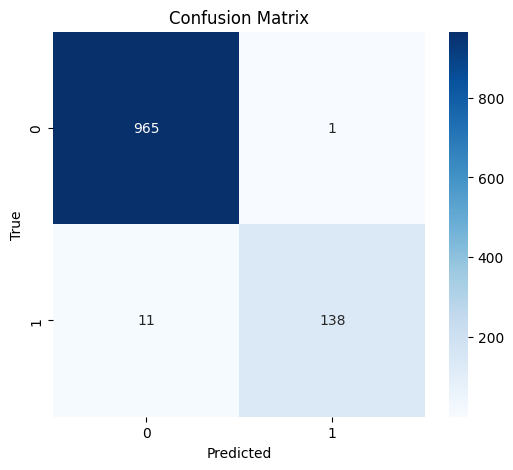

In [7]:
trainer = Trainer(model, optimizer, loss_func, device)

trainer.train(train_loader, epochs=11)

trainer.evaluate_test(test_loader)